# Loading packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pysolve3.model import Model
from pysolve3.utils import ShockModel, SolveSFC

import sympy as sp
from sympy import pprint, solve, solveset, Eq, Symbol, symbols, Function

Creating model function

In [2]:
def model():
    model = Model()

    # Accounting
    model.set_var_default(0)
    model.var('Y', desc='GDP', default = 31.372549019607845)
    model.var('C', desc='Consumption', default = 14.640522875816991)
    model.var('Id', desc='Investment', default = 6.274509803921569) # I is reserved to numpy
    model.var('Omega', desc='Wage share')
    model.var('Pi', desc='Profit share', default = 0.411765)
    
    # Identities
    model.var('K', desc='Capital Stock', default = 100)
    #model.var('K', desc='Capital Stock', default = 98.03922)
    model.var('gk', desc='Capital Stock growth rate')
    model.var('Yfc', desc='Full Capacity out-put')
    model.var('u', desc='Capacity utilization ration')
    
    # Households
    model.var('Yh', desc='Households’ income')
    model.var('Ydh', desc='Households’ disposable income')
    model.var('W', desc='Wages')
    model.var('FD', desc='Profits', default = 6.829805584130843)
    model.var('Mh', desc='Bank deposits')
    model.var('B', desc='Government Bills', default = 73.65483130189038)
    model.var('Sh', desc='Savings of Household', default = 3.1655184596361137)
    model.var('Vh', desc='Household net wealth', default = 161.44144144144184)
    model.var('pe', desc='Equities price', default = 0.9880216216216237)
    model.var('Lambda', desc='proportion of household wealth allocated in equities')
    model.var('Eq', desc='Equities', default = 9.80392156862745) # E is reserved for sympy

    # Firms
    model.var('Lf', desc='Firms Loans', default = 78.29005476064303)
    model.var('FU', desc='Retained profits', default = 4.553203722753896)
    model.var('Ft', desc='Total profits')
    model.var('Fg', desc='Gross Profits')
    model.var('h', desc='Propensity to invest', default = 0.2)
    
    
    # Government
    model.var('G', desc='Government Expenditure', default = 10.457516339869283)
    model.var('T', desc='Taxes')
    
    # Profits
    model.var('rn', desc='Net profit rate')
    model.var('rg', desc='Gross profit rate')
    
    # Accouting
    model.param('v', desc='Capital-Output ratio', default = 2.5)
    model.param('mu', desc='Mark-up', default = 0.7)
    
    #-----------------------------
    # Identities
    model.param('delta', desc='Depreciation', default = 0.044)
    
    # Households
    model.param('lambda_0', desc='Expectation of return', default = 0.08)
    model.param('alpha1', desc='Consumption Sensitivity of wages', default = 0.8)
    model.param('alpha2', desc='Consumption Sensitivity of wealth', default = 0.03375)
    model.param('rm', desc= 'Deposits interest rate', default = 0.02)
    model.param('rb', desc= 'Bills interest rate', default = 0.02)
    #model.param('rm', desc= 'Deposits interest rate', default = 0)
    #model.param('rb', desc= 'Bills interest rate', default = 0)
    model.param('tau', desc='Direct taxes', default = 0.37)
    
    # Firms
    model.param('sf', desc='Distribution of profits', default = 0.4)
    model.param('a', desc='Fixed parameter', default = 0.1)
    model.param('gamma', desc='adjstment parameter', default = 0.014)
    model.param('un', desc='Natural capacity utilization rate', default = 0.8)
    
    
    # Government
    model.param('sigma', desc='Government expenditure rate', default = 0.34)
    
    
    #-----------------------------
    model.add('B = B(-1) + G - T + rb*B(-1)') # Eq (1) # Checked
    model.add('G = sigma*Y(-1)') # Eq (2) # Checked
    #model.add('G = sigma*Y') # Eq (2)
    model.add('T= tau*Yh') # Eq (3) # Checked
    model.add('Yh = W + FD + rm*(B(-1) + Mh(-1))') # Eq (4) # Checked
    model.add('W = (1-Pi)*Y') # Eq (5) # Checked
    model.add('Ydh = (1-tau)*Yh') # Eq (6) # Checked
    model.add('C = alpha1*(1-tau)*W + alpha2*Vh(-1)') # Eq (7) # Checked
    model.add('Sh = Ydh - C') # Eq (8) # Checked
    model.add('Lambda = lambda_0 - rb') # Eq (9) # Checked
    model.add('pe = (Lambda*Vh)/Eq') # Dynamic # Eq (10) # Checked
    model.add('Vh = Vh(-1) + Sh + d(pe)*Eq(-1)') # Eq (11) # Checked
    model.add('Mh = Mh(-1) + Sh - pe*d(Eq) - d(B)') # Eq (12) # Checked
    model.add('Pi = mu/(1+mu)') # Eq (13) # Checked
    model.add('Omega = 1 - Pi') # Aux (1) # Checked
    model.add('Id = h*Y') # Eq (14) # Checked
    model.add('h = h(-1) + if_true(u - un > 0.001)*h(-1)*gamma*(u-un) + if_true(un - u > 0.001)*h(-1)*gamma*(u-un)') # Eq (15)
    model.add('K = K(-1) + Id - delta*K(-1)') # Eq (16) # Corrected (delta*K(-1))
    model.add('Yfc = K(-1)/v') # Eq (17) # Checked
    model.add('u = Y/Yfc') # Eq (18) # Checked
    model.add('gk = (h*u)/v - delta') # Eq (19) # Checked
    model.add('Lf = Lf(-1) + Id - FU - pe*d(Eq)') # Eq (20) # Checked
    model.add('Eq = a*K(-1)') # Eq (21) # Checked
    #model.add('Eq = a*K') # Eq (21)
    model.add('FU = sf*(Pi*Y - rm*Lf(-1))') # Eq (22) # Checked
    model.add('FD= (1-sf)*(Pi*Y - rm*Lf(-1))') # Eq (23) # Checked
    model.add('Ft = (Pi*Y - rm*Lf(-1))') # Eq (24) # Checked
    model.add('Fg = Pi*Y') # Eq (25)
    model.add('rn = Pi*u/v - rb*(Lf(-1))/K(-2)') # Eq (26)
    model.add('rg = Pi*u/v') # Eq (26)

    model.add('Y = C + Id + G') # Eq (28)
    #----------------
    model.var('Z', desc='Autonomous')
    
    model.add('Z = alpha2*Vh(-1)')
    
    model.var('gB', desc='Government bounds growth rate')
    model.add('gB = d(B)/B(-1)')
    
    
    model.var('gVh', desc='Vh growth rate')
    model.add('gVh = d(Vh)/Vh(-1)')
    
    model.var('alpha3', desc='Total propensity to consume out of income')
    model.var('alpha3_resid')
    
    model.add('alpha3 = C/Y')
    model.add('alpha3_resid = 1 - sigma - h')
    
    return model
  
t_check = 100
print('Evaluating consistenty at time = {}'.format(t_check))

test = model()
SolveSFC(test, time=t_check, table = False)
evaldf = pd.DataFrame({
    'Households stocks' : test.evaluate('d(Mh) - d(Vh)'),
    'Households flow' : test.evaluate('d(Mh) - Sh - pe*d(Eq)'),
    'Firms' : test.evaluate('d(Lf) - Id + FU - pe*d(Eq)'),
    'Banks' : test.evaluate('d(Lf) - d(Mh)'),
    'Financial assets' : test.evaluate('d(Lf) - d(Mh)'),
    "Wages" : test.evaluate('W - (1-Pi)*Y'),
}, index = ['Sum'])
evaldf = evaldf.transpose()
evaldf.round(5)

Evaluating consistenty at time = 100


,Sum
Households stocks,0.00000
Households flow,-11.28386
Firms,-6.56134
Banks,-0.00000
Financial assets,-0.00000
Wages,-0.00006


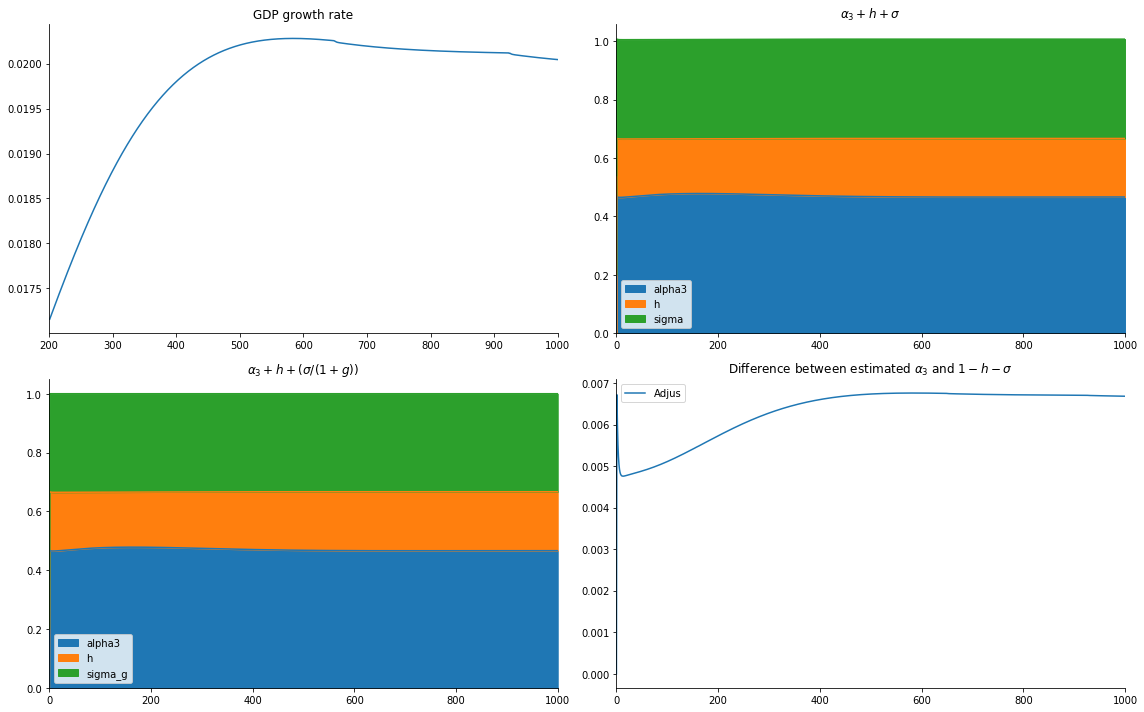

In [3]:
base = model()
df = SolveSFC(base, 1000)
df['sigma_g'] = df['sigma']/(1+df['Y'].pct_change())
df['Adjus'] = df['alpha3'] - df['alpha3_resid']

fig, ax = plt.subplots(2,2, figsize=(16,10))

df['Y'][200:].pct_change().plot(title = "GDP growth rate", ax=ax[0,0])
df[['alpha3', 'h', 'sigma']].apply(lambda x: np.abs(x)).plot(kind = 'area', stacked=True, ax=ax[0,1], title = "$\\alpha_3 + h + \sigma$")
df[['Adjus']].plot(ax=ax[1,1], title = 'Difference between estimated $\\alpha_3$ and $1-h-\sigma$')
df[['alpha3', 'h', 'sigma_g']].apply(lambda x: np.abs(x)).plot(kind = 'area', stacked=True, ax=ax[1,0], title = "$\\alpha_3 + h + (\sigma/(1+g))$")

sns.despine()
plt.tight_layout()
plt.show()

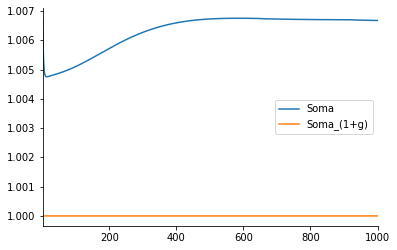

In [4]:
df["Soma"] = (df['alpha3'] + df['h'] + df['sigma'])
df["Soma_(1+g)"] = (df['alpha3'] + df['h'] + (df['sigma'])/(1+df['Y'].pct_change()))
df[["Soma", "Soma_(1+g)"]].dropna().head(15)
df[["Soma", "Soma_(1+g)"]].dropna().plot()
sns.despine()
plt.show()

1    0.020150
2    0.017893
3    0.016481
4    0.015597
5    0.015043
6    0.014698
7    0.014484
8    0.014353
9    0.014274
Name: Y, dtype: float64

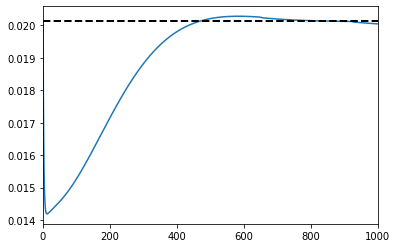

In [5]:
fig, ax = plt.subplots()

df['Y'].pct_change().plot(ax=ax)
ax.axhline(y=df['Y'].pct_change()[1], color='black', ls='--', lw=2)

df['Y'].pct_change()[:10].dropna()

# Analytical solution

In [6]:
base_eq = model()
df = SolveSFC(base_eq, time=1)
t = sp.Symbol('t')

for i in base_eq.variables:
  globals()["_" + i] = sp.Function(i)
  
for i in base_eq.parameters:
  globals()[i] = sp.symbols(i, positive=True)


## Households

In [7]:
Yh = _W(t) + _FD(t) + rm*(_Mh(t-1) + _B(t-1))
pprint(Eq(_Yh(t), Yh))
W = (1-_Pi(t))*_Y(t)
pprint(Eq(_W(t), W))
Ydh = (1-tau)*_Yh(t)
pprint(Eq(_Ydh(t), Ydh))
C = alpha1*(1-tau)*_W(t) + alpha2*_Vh(t-1)
pprint(Eq(_C(t), C))
Sh = _Ydh(t) - _C(t)
pprint(Eq(_Sh(t), Sh))
Vh = _Vh(t-1) + _Sh(t) + (_pe(t) - _pe(t-1))*_Eq(t-1)
pprint(Eq(_Vh(t),Vh ))
Mh = _Mh(t-1) + _Sh(t) - _pe(t)*(_Eq(t) - _Eq(t-1)) - (_B(t) - _B(t-1))
pprint(Eq(_Mh(t),Mh ))

Yh(t) = rm⋅(B(t - 1) + Mh(t - 1)) + FD(t) + W(t)
W(t) = (1 - Π(t))⋅Y(t)
Ydh(t) = (1 - τ)⋅Yh(t)
C(t) = α₁⋅(1 - τ)⋅W(t) + α₂⋅Vh(t - 1)
Sh(t) = -C(t) + Ydh(t)
Vh(t) = (pe(t) - pe(t - 1))⋅Eq(t - 1) + Sh(t) + Vh(t - 1)
Mh(t) = -(Eq(t) - Eq(t - 1))⋅pe(t) - B(t) + B(t - 1) + Mh(t - 1) + Sh(t)


## Government

In [8]:
#G = sigma*_Y(t-1)
G = sigma*_Y(t)
pprint(Eq(_G(t), G))
T = tau*_Yh(t)
pprint(Eq(_T(t), T))
B = _B(t-1) + (_G(t)-_T(t)) + rm*_B(t-1)
pprint(Eq(_B(t), B))

G(t) = σ⋅Y(t)
T(t) = τ⋅Yh(t)
B(t) = rm⋅B(t - 1) + B(t - 1) + G(t) - T(t)


## Firms

In [9]:
Pi = mu/(1+mu)
pprint(Eq(_Pi(t), Pi))
Id = _h(t)*_Y(t)
pprint(Eq(_Id(t), Id))
h = _h(t-1)*(gamma*(_u(t) - un)) + _h(t-1)
pprint(Eq(_h(t), h))
K = _Id(t) + _K(t-1) - delta*_K(t-1) 
pprint(Eq(_K(t),K))
Yfc = _K(t-1)/v
pprint(Eq(_Yfc(t), Yfc))
u = _Y(t)/_Yfc(t)
pprint(Eq(_u(t), u))
gk = _h(t)*_u(t)/v
pprint(Eq(_gk(t), gk))
Lf = _Lf(t-1) + _Id(t) - _FU(t) - _pe(t)*(_Eq(t) - _Eq(t-1))
pprint(Eq(_Lf(t), Lf))
Ft = _Pi(t)*_Y(t) - rm*_Lf(t)
pprint(Eq(_Ft(t), Ft))
FU = sf*_Ft(t)
pprint(Eq(_FU(t), FU))
FD = (1-sf)*_Ft(t)
pprint(Eq(_FD(t), FD))
Lambda = lambda_0 - rm
pprint(Eq(_Lambda(t), Lambda))
pe = _Lambda(t)*_Vh(t)/_Eq(t)
pprint(Eq(_pe(t), pe))
E = a*_K(t-1)
pprint(Eq(_Eq(t), E))

         μ  
Π(t) = ─────
       μ + 1
Id(t) = Y(t)⋅h(t)
h(t) = γ⋅(-un + u(t))⋅h(t - 1) + h(t - 1)
K(t) = -δ⋅K(t - 1) + Id(t) + K(t - 1)
         K(t - 1)
Yfc(t) = ────────
            v    
        Y(t) 
u(t) = ──────
       Yfc(t)
        h(t)⋅u(t)
gk(t) = ─────────
            v    
Lf(t) = -(Eq(t) - Eq(t - 1))⋅pe(t) - FU(t) + Id(t) + Lf(t - 1)
Ft(t) = -rm⋅Lf(t) + Π(t)⋅Y(t)
FU(t) = sf⋅Ft(t)
FD(t) = (1 - sf)⋅Ft(t)
Λ(t) = λ₀ - rm
        Λ(t)⋅Vh(t)
pe(t) = ──────────
          Eq(t)   
Eq(t) = a⋅K(t - 1)


## Goods market

In [10]:
Y = _C(t) + _Id(t) + _G(t)
pprint(Eq(_Y(t), Y))

Y(t) = C(t) + G(t) + Id(t)


Replacing

In [47]:
omega, g = symbols('omega g_Z')

EqY = Y - _Y(t)
pprint(Eq(EqY, 0))
EqY = EqY.subs(_Id(t), Id).subs(_C(t), C).subs(_G(t), G)
pprint(Eq(EqY, 0))
EqY = EqY.subs(_W(t), W).subs(_Pi(t), (1- omega))
pprint(Eq(EqY, 0))
EqY = EqY.subs(_Ydh(t), Ydh).subs(_Yh(t), Yh)
pprint(Eq(EqY, 0))
EqY = EqY.subs(_Vh(t-1), _Vh(t)/(1+g)).subs(_Y(t-1), _Y(t)/(1+g))

print("\nReplacing t-1 variables by t/(1+g) variables and solving\n")
pprint(Eq(EqY, 0))
sol = solve(EqY, _Y(t))[0]
pprint(Eq(_Y(t), sol.collect(alpha1).collect(_h(t)).collect(mu)))

print("\nReplacing Vh\n")
sol = sol.subs(_Vh(t), Vh)
pprint(Eq(_Y(t), sol))

print('\nReplacing Sh, C and so on\n')
sol = sol.subs(_Sh(t), Sh)
pprint(Eq(_Y(t), sol))

sol = sol.subs(_C(t), C)
pprint(Eq(_Y(t), sol))
sol = sol.subs(_W(t), W).subs(_Pi(t), (1- omega))
pprint(Eq(_Y(t), sol))
sol = sol.subs(_Y(t), Y).subs(_C(t), C).subs(_W(t), W).subs(_Pi(t), (1- omega)).subs(_Id(t), Id).subs(_G(t), G)
pprint(Eq(_Y(t), sol))

print("Replacing t-1 variables by t/(1+g) variables and solving")
sol = sol -_Y(t)
sol = solve(sol, _Y(t))[0]
pprint(Eq(_Y(t), sol))
sol = solve(sol, _Ydh(t))[0]
pprint(Eq(_Ydh(t), sol.collect(alpha1).collect(_h(t)).collect(mu)))
sol = (sol/_Vh(t-1)).simplify().collect(_Eq(t-1)).collect(_Vh(t-1))
pprint(Eq(_Ydh(t)/_Vh(t-1), sol))

Cc, gVh = symbols('Cc g_Vh')

print('\nLet Cc be the capital gain share on Vh growth rate')
pprint(Eq(_Vh(t), Vh))
pprint(Eq(Cc, ((-_pe(t) + _pe(t - 1))*_Eq(t - 1))/_Vh(t-1)))
pprint(Eq(gVh, Cc + (_Sh(t)/_Vh(t-1))))

print("\nReplacing")
sol = sol.subs(((-_pe(t) + _pe(t - 1))*_Eq(t - 1))/_Vh(t-1), Cc)
sol = sol.collect(alpha1*omega).collect(alpha2)
pprint(Eq(_Ydh(t)/_Vh(t-1), sol))



C(t) + G(t) + Id(t) - Y(t) = 0
α₁⋅(1 - τ)⋅W(t) + α₂⋅Vh(t - 1) + σ⋅Y(t) + Y(t)⋅h(t) - Y(t) = 0
α₁⋅ω⋅(1 - τ)⋅Y(t) + α₂⋅Vh(t - 1) + σ⋅Y(t) + Y(t)⋅h(t) - Y(t) = 0
α₁⋅ω⋅(1 - τ)⋅Y(t) + α₂⋅Vh(t - 1) + σ⋅Y(t) + Y(t)⋅h(t) - Y(t) = 0

Replacing t-1 variables by t/(1+g) variables and solving

                    α₂⋅Vh(t)                                
α₁⋅ω⋅(1 - τ)⋅Y(t) + ──────── + σ⋅Y(t) + Y(t)⋅h(t) - Y(t) = 0
                    g_Z + 1                                 
                                      α₂⋅Vh(t)                               
Y(t) = ──────────────────────────────────────────────────────────────────────
       α₁⋅(g_Z⋅ω⋅τ - g_Z⋅ω + ω⋅τ - ω) - g_Z⋅σ + g_Z - σ + (-g_Z - 1)⋅h(t) + 1

Replacing Vh

                   α₂⋅((pe(t) - pe(t - 1))⋅Eq(t - 1) + Sh(t) + Vh(t - 1))     
Y(t) = ───────────────────────────────────────────────────────────────────────
       α₁⋅g_Z⋅ω⋅τ - α₁⋅g_Z⋅ω + α₁⋅ω⋅τ - α₁⋅ω - g_Z⋅σ - g_Z⋅h(t) + g_Z - σ - h(

      
──────
t) + 1

Replacing Sh, C and so on